In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation

## Time series

In [2]:
def read_ts_df(case, org):

    df = pd.read_csv('../output/'+case+'/ts_'+org+'.csv', header=[0, 1, 2], index_col=[0])
    df.index = pd.to_datetime(df.index)
    
    return df

In [3]:
case = 'us'
df_dw = read_ts_df(case, 'dw')
df_meso = read_ts_df(case, 'meso')

# df.columns.levels[1]
# df['40'][df.columns.levels[1][0]].columns == 'sodar_ws'
# df.columns.levels[2]

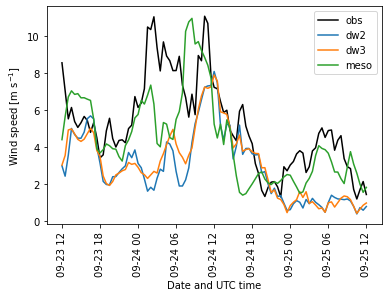

In [4]:
fig, ax = plt.subplots()
ax.plot(df_dw.index, df_dw['40']['dw2km']['sodar_ws'], label='obs', c='k')
ax.plot(df_dw.index, df_dw['40']['dw2km']['dw2km_ws'], label='dw2')
ax.plot(df_dw.index, df_dw['40']['dw3km']['dw3km_ws'], label='dw3')
ax.plot(df_meso.index, df_meso['40']['meso']['meso_ws'], label='meso')
plt.xticks(rotation=90)
plt.xlabel('Date and UTC time')
plt.ylabel(r'Wind speed [m s$^{-1}$]')
plt.legend()
plt.show()

## Metrics

In [8]:
def read_metrics_df(case, org):

    return pd.read_csv('../output/'+case+'/metrics_'+org+'.csv', header=[0, 1, 2], index_col=[0])

case = 'us'
org_list = ['dw', 'meso']

for ind, org in enumerate(org_list):
    
    df = read_metrics_df(case, org)
    
    if ind == 0: 
        df_metrics = df
    else:
        df_metrics = df_metrics.join(df)

In [9]:
df_metrics

40                    80                   120             \
              dw2km      dw3km      dw2km      dw3km      dw2km      dw3km   
           dw2km_ws   dw3km_ws   dw2km_ws   dw3km_ws   dw2km_ws   dw3km_ws   
rmse       3.169623   2.937434   3.301379   3.066503   3.239863   3.075049   
crmse      2.187700   1.998103   2.337905   2.090134   2.426677   2.179937   
bias      -2.293574  -2.153162  -2.330945  -2.243832  -2.146614  -2.168825   
bias_pct -40.475926 -38.183620 -38.433583 -36.702674 -32.073032 -32.170055   
mae        2.431787   2.283402   2.537955   2.388024   2.460509   2.361316   
mae_pct   46.202997  44.355917  45.197324  43.067276  41.833744  40.898972   

                 40         80        120  
               meso       meso       meso  
            meso_ws    meso_ws    meso_ws  
rmse       2.094536   2.319689   2.464345  
crmse      1.932294   2.232804   2.354239  
bias      -0.808283  -0.628921  -0.728390  
bias_pct  -9.551043 -11.262994 -12.575055  
mae        1.574331   1.705280   1.826414  
mae_pct   30.426322  30.180954  31.076515

## Ramps

In [3]:
def triangulation_for_triheatmap(M, N):
    xv, yv = np.meshgrid(np.arange(-0.5, M), np.arange(-0.5, N))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, M), np.arange(0, N))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (M + 1) * (N + 1)  # indices of the centers

    trianglesN = [(i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesE = [(i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesS = [(i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesW = [(i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]

In [204]:
rdf1 = pd.read_csv('../output/us/ramp_dw.csv', header=[0, 1, 2, 3], index_col=[0])
rdf2 = pd.read_csv('../output/us/ramp_meso.csv', header=[0, 1, 2, 3], index_col=[0])
rdf = rdf1.join(rdf2)
rdf3 = pd.read_csv('../output/us/ramp_nrel.csv', header=[0, 1, 2, 3], index_col=[0])
rdf = rdf.join(rdf3)

srdf = rdf.loc(axis=1)['40', : , :, :][:4].T
srdf.index.set_names(['t1', 't2', 't3', 't4'], inplace=True)

p_srdf = srdf.pivot_table(index='t4', columns='t3')

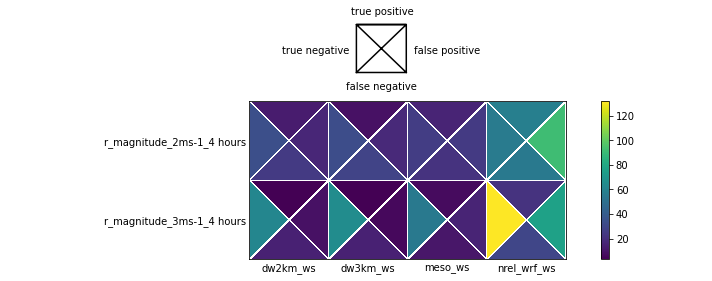

In [206]:
M = len(p_srdf.columns) // 4
N = len(p_srdf)
values = [p_srdf[dir] for dir in
          srdf.columns]  # these are the 4 column names in df

triangul = triangulation_for_triheatmap(M, N)
cmaps = ['viridis'] * 4
norms = [plt.Normalize(p_srdf.min().min(), p_srdf.max().max()) for _ in range(4)]

fig, (axl, ax) = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'height_ratios': [1, 3]})

imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
        for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]
# imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, ec='white')
#         for t, val, cmap in zip(triangul, values, cmaps)]

ax.tick_params(length=0)
ax.set_xticks(range(M))
ax.set_xticklabels(srdf.index.get_level_values(2).unique())
ax.set_yticks(range(N))
ax.set_yticklabels(p_srdf.index)
ax.invert_yaxis()
ax.margins(x=0, y=0)
ax.set_aspect('equal', 'box')  # square cells
plt.colorbar(imgs[3], ax=ax)

# axl.plot((1, 9), (1, 9), c='k', transform=ax.transAxes)
axl.plot((0, 0, 1, 1, 0, 1, 0, 1), (0, 1, 1, 0, 0, 1, 1, 0), c='k')
# axl.plot((0, 1), (0, 1), c='k')
# axl.plot((0, 1), (1, 0), c='k')
axl.set_xlim(-7, 7)
axl.text(-1.5, 0.4, 'true negative', c='k')
axl.text(-0.1, 1.2, 'true positive', c='k')
axl.text(1.15, 0.4, 'false positive', c='k')
axl.text(-0.2, -0.35, 'false negative', c='k')

# axl.text(0.05, 1.3, 'true negative', c='k', transform=ax.transAxes)
# axl.text(0.6, 1.3, 'false positive', c='k', transform=ax.transAxes)
# axl.text(0.35, 1.05, 'false negative', c='k', transform=ax.transAxes)
# axl.text(0.35, 1.6, 'true positive', c='k', transform=ax.transAxes)
axl.axis(False)

# ax.plot((1.8, 0.5), (1.8, 0.8), c='k', transform = ax.transAxes)

plt.tight_layout()
plt.show()

In [7]:
p_srdf

false_negative                  false_positive  \
t3                              dw2km_ws dw3km_ws meso_ws       dw2km_ws   
t4                                                                         
r_magnitude_2ms-1_4 hours           25.0     29.0    22.0           17.0   
r_magnitude_3ms-1_4 hours           15.0     15.0    11.0            9.0   

                                           true_negative                   \
t3                        dw3km_ws meso_ws      dw2km_ws dw3km_ws meso_ws   
t4                                                                          
r_magnitude_2ms-1_4 hours     18.0    25.0          34.0     33.0    26.0   
r_magnitude_3ms-1_4 hours      6.0    16.0          62.0     65.0    55.0   

                          true_positive                   
t3                             dw2km_ws dw3km_ws meso_ws  
t4                                                        
r_magnitude_2ms-1_4 hours          13.0      9.0    16.0  
r_magnitude_3ms-1_4 hours           3.0      3.0     7.0

In [5]:
rdf['40']['dw2km']['dw2km_ws']['r_magnitude_2ms-1_4 hours']

true_positive               13.000000
false_positive              17.000000
false_negative              25.000000
true_negative               34.000000
probability_of_detection     0.342105
critical_success_index       0.236364
frequency_bias_score         0.789474
false_alarm_ratio            0.566667
forecast_accuracy            0.433333
Name: r_magnitude_2ms-1_4 hours, dtype: float64

In [6]:
srdf = rdf.loc(axis=1)['40', : , :, :][:4].T
srdf.index.set_names(['t1', 't2', 't3', 't4'], inplace=True)
srdf

true_positive  false_positive  \
t1 t2    t3       t4                                                         
40 dw2km dw2km_ws r_magnitude_2ms-1_4 hours           13.0            17.0   
                  r_magnitude_3ms-1_4 hours            3.0             9.0   
   dw3km dw3km_ws r_magnitude_2ms-1_4 hours            9.0            18.0   
                  r_magnitude_3ms-1_4 hours            3.0             6.0   
   meso  meso_ws  r_magnitude_2ms-1_4 hours           16.0            25.0   
                  r_magnitude_3ms-1_4 hours            7.0            16.0   

                                             false_negative  true_negative  
t1 t2    t3       t4                                                        
40 dw2km dw2km_ws r_magnitude_2ms-1_4 hours            25.0           34.0  
                  r_magnitude_3ms-1_4 hours            15.0           62.0  
   dw3km dw3km_ws r_magnitude_2ms-1_4 hours            29.0           33.0  
                  r_magnitude_3ms-1_4 hours            15.0           65.0  
   meso  meso_ws  r_magnitude_2ms-1_4 hours            22.0           26.0  
                  r_magnitude_3ms-1_4 hours            11.0           55.0

In [7]:
p_srdf = srdf.pivot_table(index='t4', columns='t3')
p_srdf

false_negative                  false_positive  \
t3                              dw2km_ws dw3km_ws meso_ws       dw2km_ws   
t4                                                                         
r_magnitude_2ms-1_4 hours           25.0     29.0    22.0           17.0   
r_magnitude_3ms-1_4 hours           15.0     15.0    11.0            9.0   

                                           true_negative                   \
t3                        dw3km_ws meso_ws      dw2km_ws dw3km_ws meso_ws   
t4                                                                          
r_magnitude_2ms-1_4 hours     18.0    25.0          34.0     33.0    26.0   
r_magnitude_3ms-1_4 hours      6.0    16.0          62.0     65.0    55.0   

                          true_positive                   
t3                             dw2km_ws dw3km_ws meso_ws  
t4                                                        
r_magnitude_2ms-1_4 hours          13.0      9.0    16.0  
r_magnitude_3ms-1_4 hours           3.0      3.0     7.0

In [27]:
p_srdf.max().max()

65.0

In [28]:
p_srdf.min().min()

3.0

In [8]:
M = len(p_srdf.columns) // 4
N = len(p_srdf)
values = [p_srdf[dir] for dir in
          srdf.columns]  # these are the 4 column names in df

In [20]:
values

[t3                         dw2km_ws  dw3km_ws  meso_ws
 t4                                                    
 r_magnitude_2ms-1_4 hours      13.0       9.0     16.0
 r_magnitude_3ms-1_4 hours       3.0       3.0      7.0,
 t3                         dw2km_ws  dw3km_ws  meso_ws
 t4                                                    
 r_magnitude_2ms-1_4 hours      17.0      18.0     25.0
 r_magnitude_3ms-1_4 hours       9.0       6.0     16.0,
 t3                         dw2km_ws  dw3km_ws  meso_ws
 t4                                                    
 r_magnitude_2ms-1_4 hours      25.0      29.0     22.0
 r_magnitude_3ms-1_4 hours      15.0      15.0     11.0,
 t3                         dw2km_ws  dw3km_ws  meso_ws
 t4                                                    
 r_magnitude_2ms-1_4 hours      34.0      33.0     26.0
 r_magnitude_3ms-1_4 hours      62.0      65.0     55.0]

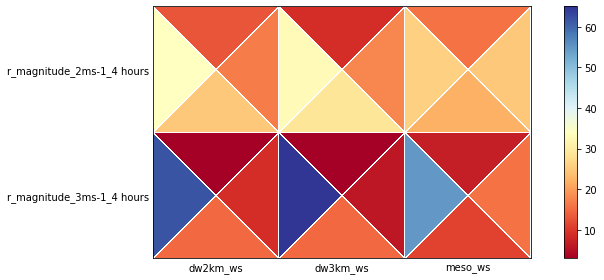

In [29]:
# M = len(p_srdf.columns) // 4
# N = len(p_srdf)
# values = [p_srdf[dir] for dir in
#           srdf.columns]  # these are the 4 column names in df

triangul = triangulation_for_triheatmap(M, N)
cmaps = ['RdYlBu'] * 4
norms = [plt.Normalize(p_srdf.min().min(), p_srdf.max().max()) for _ in range(4)]
fig, ax = plt.subplots(figsize=(10, 4))
imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
        for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]
# imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, ec='white')
#         for t, val, cmap in zip(triangul, values, cmaps)]

ax.tick_params(length=0)
ax.set_xticks(range(M))
ax.set_xticklabels(srdf.index.get_level_values(2).unique())
ax.set_yticks(range(N))
ax.set_yticklabels(p_srdf.index)
ax.invert_yaxis()
ax.margins(x=0, y=0)
ax.set_aspect('equal', 'box')  # square cells
plt.colorbar(imgs[3], ax=ax)
plt.tight_layout()
plt.show()

In [113]:
p_srdf

false_negative                  false_positive  \
t3                              dw2km_ws dw3km_ws meso_ws       dw2km_ws   
t4                                                                         
r_magnitude_2ms-1_4 hours           25.0     29.0    22.0           17.0   
r_magnitude_3ms-1_4 hours           15.0     15.0    11.0            9.0   

                                           true_negative                   \
t3                        dw3km_ws meso_ws      dw2km_ws dw3km_ws meso_ws   
t4                                                                          
r_magnitude_2ms-1_4 hours     18.0    25.0          34.0     33.0    26.0   
r_magnitude_3ms-1_4 hours      6.0    16.0          62.0     65.0    55.0   

                          true_positive                   
t3                             dw2km_ws dw3km_ws meso_ws  
t4                                                        
r_magnitude_2ms-1_4 hours          13.0      9.0    16.0  
r_magnitude_3ms-1_4 hours           3.0      3.0     7.0

In [65]:
rdf.loc(axis=1)['40', : , :, :][:4].T.columns

Index(['true_positive', 'false_positive', 'false_negative', 'true_negative'], dtype='object')

In [67]:
rdf.loc(axis=1)['40', : , :, :][:4].T.index

MultiIndex([('40', 'dw2km', 'dw2km_ws', 'r_magnitude_2ms-1_4 hours'),
            ('40', 'dw2km', 'dw2km_ws', 'r_magnitude_3ms-1_4 hours'),
            ('40', 'dw3km', 'dw3km_ws', 'r_magnitude_2ms-1_4 hours'),
            ('40', 'dw3km', 'dw3km_ws', 'r_magnitude_3ms-1_4 hours'),
            ('40',  'meso',  'meso_ws', 'r_magnitude_2ms-1_4 hours'),
            ('40',  'meso',  'meso_ws', 'r_magnitude_3ms-1_4 hours')],
           )

In [75]:
srdf.index.set_names(['t1', 't2', 't3', 't4'], inplace=True)

In [76]:
srdf.index.get_level_values(0)

Index(['40', '40', '40', '40', '40', '40'], dtype='object', name='t1')

In [71]:
srdf.pivot_table(index='level1')

KeyError: 'level1'

In [ ]:
df_piv = df.pivot_table(index='rows', columns='cols')

In [64]:
df.columns

Index(['cols', 'rows', 'north', 'east', 'south', 'west'], dtype='object')

In [54]:
df

,cols,rows,north,east,south,west
0,h,Fri,0.051642,0.033197,0.298103,0.028917
1,g,Thu,0.058756,0.468158,0.314536,0.114135
2,f,Tue,0.271725,0.780174,0.307855,0.138555
3,j,Fri,0.417720,0.405453,0.903613,0.378651
4,i,Tue,0.169375,0.563734,0.336128,0.870945
5,e,Tue,0.964234,0.387148,0.916675,0.146984
6,g,Thu,0.751938,0.608342,0.692106,0.361135
7,j,Fri,0.529482,0.141763,0.713343,0.237405
8,g,Thu,0.728243,0.233336,0.105105,0.776263
9,g,Wed,0.060980,0.085120,0.517860,0.165905


In [53]:
df_piv

east                                                              \
cols         a         b         c         d         e         f         g   
rows                                                                         
Mon   0.642677  0.236812       NaN       NaN  0.672720  0.530699  0.882173   
Tue   0.572020       NaN  0.620456  0.774746  0.381096       NaN       NaN   
Wed   0.799041  0.486874       NaN       NaN  0.538312       NaN  0.226859   
Thu   0.646024  0.585428  0.115686  0.287900       NaN  0.582402  0.553035   
Fri        NaN  0.678439  0.609984  0.612498       NaN  0.250010  0.584306   

                                    ...      west                      \
cols         h         i         j  ...         a         b         c   
rows                                ...                                 
Mon   0.170828       NaN       NaN  ...  0.503376  0.721817       NaN   
Tue        NaN  0.607236       NaN  ...  0.464243       NaN  0.035659   
Wed        NaN       NaN       NaN  ...  0.647487  0.494837       NaN   
Thu   0.674968  0.417233       NaN  ...  0.750955  0.043111  0.269935   
Fri   0.690357  0.682419  0.107392  ...       NaN  0.912974  0.681874   

                                                                            
cols         d         e         f         g         h         i         j  
rows                                                                        
Mon        NaN  0.647135  0.627667  0.846230  0.506537       NaN       NaN  
Tue   0.412505  0.073849       NaN       NaN       NaN  0.996135       NaN  
Wed        NaN  0.507857       NaN  0.100181       NaN       NaN       NaN  
Thu   0.230988       NaN  0.844105  0.470199  0.480377  0.111964       NaN  
Fri   0.652258       NaN  0.498647  0.267053  0.444233  0.754874  0.921554  

[5 rows x 40 columns]

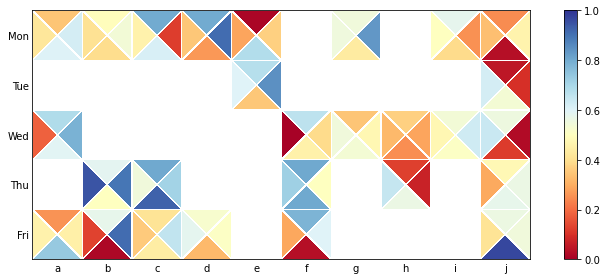

In [99]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
df = pd.DataFrame({'cols': np.random.choice([*'abcdefghij'], 40),
                   'rows': np.random.choice(days, 40),
                   'north': np.random.rand(40),
                   'east': np.random.rand(40),
                   'south': np.random.rand(40),
                   'west': np.random.rand(40)})
df['rows'] = pd.Categorical(df['rows'], categories=days)  # fix an ordering
df_piv = df.pivot_table(index='rows', columns='cols')
M = len(df_piv.columns) // 4
N = len(df_piv)
values = [df_piv[dir] for dir in
          ['north', 'east', 'south', 'west']]  # these are the 4 column names in df

triangul = triangulation_for_triheatmap(M, N)
cmaps = ['RdYlBu'] * 4
norms = [plt.Normalize(0, 1) for _ in range(4)]
fig, ax = plt.subplots(figsize=(10, 4))
imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
        for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]

ax.tick_params(length=0)
ax.set_xticks(range(M))
ax.set_xticklabels(df_piv['north'].columns)
ax.set_yticks(range(N))
ax.set_yticklabels(df_piv.index)
ax.invert_yaxis()
ax.margins(x=0, y=0)
ax.set_aspect('equal', 'box')  # square cells
plt.colorbar(imgs[0], ax=ax)
plt.tight_layout()
plt.show()

In [101]:
df_piv

east                                                              \
cols         a         b         c         d         e         f         g   
rows                                                                         
Mon   0.624433  0.542296  0.122082  0.913472  0.367647       NaN  0.837058   
Tue        NaN       NaN       NaN       NaN  0.850536       NaN       NaN   
Wed   0.785477       NaN       NaN       NaN       NaN  0.391732  0.475194   
Thu        NaN  0.894544  0.714256       NaN       NaN  0.500946       NaN   
Fri   0.450639  0.912537  0.659316  0.510254       NaN  0.600033       NaN   

                                    ...      west                      \
cols         h         i         j  ...         a         b         c   
rows                                ...                                 
Mon        NaN  0.256062  0.463154  ...  0.423500  0.406969  0.459164   
Tue        NaN       NaN  0.098067  ...       NaN       NaN       NaN   
Wed   0.286137  0.631778  0.026776  ...  0.180689       NaN       NaN   
Thu   0.072264       NaN  0.564254  ...       NaN  0.952044  0.547721   
Fri        NaN       NaN  0.548225  ...  0.457398  0.132284  0.356262   

                                                                            
cols         d         e         f         g         h         i         j  
rows                                                                        
Mon   0.348544  0.285866       NaN  0.554311       NaN  0.503543  0.335839  
Tue        NaN  0.599635       NaN       NaN       NaN       NaN  0.621227  
Wed        NaN       NaN  0.006369  0.547594  0.321301  0.473339  0.643317  
Thu        NaN       NaN  0.720126       NaN  0.651567       NaN  0.293736  
Fri   0.585067       NaN  0.290821       NaN       NaN       NaN  0.411712  

[5 rows x 40 columns]

In [100]:
values

[cols         a         b         c         d         e         f         g  \
 rows                                                                         
 Mon   0.346107  0.494976  0.804414  0.801373  0.015220       NaN  0.548690   
 Tue        NaN       NaN       NaN       NaN  0.678792       NaN       NaN   
 Wed   0.690750       NaN       NaN       NaN       NaN  0.666744  0.346081   
 Thu        NaN  0.587703  0.806598       NaN       NaN  0.805035       NaN   
 Fri   0.259934  0.576884  0.410527  0.524066       NaN  0.783398       NaN   
 
 cols         h         i         j  
 rows                                
 Mon        NaN  0.579769  0.247584  
 Tue        NaN       NaN  0.050587  
 Wed   0.369284  0.541180  0.557641  
 Thu   0.126036       NaN  0.477080  
 Fri        NaN       NaN  0.562118  ,
 cols         a         b         c         d         e         f         g  \
 rows                                                                         
 Mon   0.624433  0.5

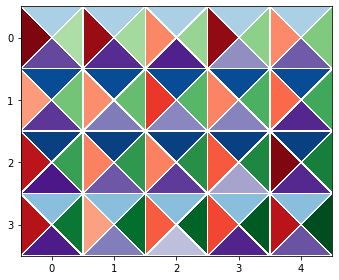

In [96]:
from matplotlib.tri import Triangulation
import numpy as np

def create_demo_data(M, N):
    # create some demo data for North, East, South, West
    # note that each of the 4 arrays can be either 2D (N by M) or 1D (N*M)
    # M columns and N rows
    valuesN = np.repeat(np.abs(np.sin(np.arange(N))), M)
    valuesE = np.arange(M * N) / (N * M)
    valuesS = np.random.uniform(0, 1, (N, M))
    valuesW = np.random.uniform(0, 1, (N, M))
    return [valuesN, valuesE, valuesS, valuesW]

def triangulation_for_triheatmap(M, N):
    xv, yv = np.meshgrid(np.arange(-0.5, M), np.arange(-0.5, N))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, M), np.arange(0, N))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (M + 1) * (N + 1)  # indices of the centers

    trianglesN = [(i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesE = [(i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesS = [(i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesW = [(i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]

M, N = 5, 4  # e.g. 5 columns, 4 rows
values = create_demo_data(M, N)
triangul = triangulation_for_triheatmap(M, N)
cmaps = ['Blues', 'Greens', 'Purples', 'Reds']  # ['winter', 'spring', 'summer', 'autumn']
norms = [plt.Normalize(-0.5, 1) for _ in range(4)]
fig, ax = plt.subplots()
imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
        for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]

ax.set_xticks(range(M))
ax.set_yticks(range(N))
ax.invert_yaxis()
ax.margins(x=0, y=0)
ax.set_aspect('equal', 'box')  # square cells
plt.tight_layout()
plt.show()

In [95]:
imgs = [ax.tripcolor(t, val.ravel(), cmap='RdYlGn', vmin=0, vmax=1, ec='white')
        for t, val in zip(triangul, values)]
for val, dir in zip(values, [(-1, 0), (0, 1), (1, 0), (0, -1)]):
    for i in range(M):
        for j in range(N):
            v = val[j, i]
            ax.text(i + 0.3 * dir[1], j + 0.3 * dir[0], f'{v:.2f}', color='k' if 0.2 < v < 0.8 else 'w', ha='center', va='center')
cbar = fig.colorbar(imgs[0], ax=ax)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [16]:
df_piv

east                                                              \
cols         a         b         c         d         e         f         g   
rows                                                                         
Mon   0.642677  0.236812       NaN       NaN  0.672720  0.530699  0.882173   
Tue   0.572020       NaN  0.620456  0.774746  0.381096       NaN       NaN   
Wed   0.799041  0.486874       NaN       NaN  0.538312       NaN  0.226859   
Thu   0.646024  0.585428  0.115686  0.287900       NaN  0.582402  0.553035   
Fri        NaN  0.678439  0.609984  0.612498       NaN  0.250010  0.584306   

                                    ...      west                      \
cols         h         i         j  ...         a         b         c   
rows                                ...                                 
Mon   0.170828       NaN       NaN  ...  0.503376  0.721817       NaN   
Tue        NaN  0.607236       NaN  ...  0.464243       NaN  0.035659   
Wed        NaN       NaN       NaN  ...  0.647487  0.494837       NaN   
Thu   0.674968  0.417233       NaN  ...  0.750955  0.043111  0.269935   
Fri   0.690357  0.682419  0.107392  ...       NaN  0.912974  0.681874   

                                                                            
cols         d         e         f         g         h         i         j  
rows                                                                        
Mon        NaN  0.647135  0.627667  0.846230  0.506537       NaN       NaN  
Tue   0.412505  0.073849       NaN       NaN       NaN  0.996135       NaN  
Wed        NaN  0.507857       NaN  0.100181       NaN       NaN       NaN  
Thu   0.230988       NaN  0.844105  0.470199  0.480377  0.111964       NaN  
Fri   0.652258       NaN  0.498647  0.267053  0.444233  0.754874  0.921554  

[5 rows x 40 columns]

In [12]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
df = pd.DataFrame({'cols': np.random.choice([*'abcdefghij'], 40),
                   'rows': np.random.choice(days, 40),
                   'north': np.random.rand(40),
                   'east': np.random.rand(40),
                   'south': np.random.rand(40),
                   'west': np.random.rand(40)})
df

,cols,rows,north,east,south,west
0,h,Fri,0.051642,0.033197,0.298103,0.028917
1,g,Thu,0.058756,0.468158,0.314536,0.114135
2,f,Tue,0.271725,0.780174,0.307855,0.138555
3,j,Fri,0.417720,0.405453,0.903613,0.378651
4,i,Tue,0.169375,0.563734,0.336128,0.870945
5,e,Tue,0.964234,0.387148,0.916675,0.146984
6,g,Thu,0.751938,0.608342,0.692106,0.361135
7,j,Fri,0.529482,0.141763,0.713343,0.237405
8,g,Thu,0.728243,0.233336,0.105105,0.776263
9,g,Wed,0.060980,0.085120,0.517860,0.165905


In [14]:
df['rows'] = pd.Categorical(df['rows'], categories=days)  # fix an ordering
df

,cols,rows,north,east,south,west
0,h,Fri,0.051642,0.033197,0.298103,0.028917
1,g,Thu,0.058756,0.468158,0.314536,0.114135
2,f,Tue,0.271725,0.780174,0.307855,0.138555
3,j,Fri,0.417720,0.405453,0.903613,0.378651
4,i,Tue,0.169375,0.563734,0.336128,0.870945
5,e,Tue,0.964234,0.387148,0.916675,0.146984
6,g,Thu,0.751938,0.608342,0.692106,0.361135
7,j,Fri,0.529482,0.141763,0.713343,0.237405
8,g,Thu,0.728243,0.233336,0.105105,0.776263
9,g,Wed,0.060980,0.085120,0.517860,0.165905


In [15]:
df['rows']

0     Fri
1     Thu
2     Tue
3     Fri
4     Tue
5     Tue
6     Thu
7     Fri
8     Thu
9     Wed
10    Wed
11    Fri
12    Thu
13    Tue
14    Fri
15    Mon
16    Mon
17    Mon
18    Thu
19    Wed
20    Wed
21    Wed
22    Thu
23    Tue
24    Wed
25    Wed
26    Fri
27    Thu
28    Mon
29    Tue
30    Thu
31    Tue
32    Wed
33    Fri
34    Mon
35    Wed
36    Fri
37    Thu
38    Fri
39    Tue
Name: rows, dtype: category
Categories (5, object): ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

In [13]:
df['rows']

0     Fri
1     Thu
2     Tue
3     Fri
4     Tue
5     Tue
6     Thu
7     Fri
8     Thu
9     Wed
10    Wed
11    Fri
12    Thu
13    Tue
14    Fri
15    Mon
16    Mon
17    Mon
18    Thu
19    Wed
20    Wed
21    Wed
22    Thu
23    Tue
24    Wed
25    Wed
26    Fri
27    Thu
28    Mon
29    Tue
30    Thu
31    Tue
32    Wed
33    Fri
34    Mon
35    Wed
36    Fri
37    Thu
38    Fri
39    Tue
Name: rows, dtype: object